In [1]:
#02/03/2020 TO DO:

# - Create a set grid of electrodes using Network['length_x'] + Network['length_y']
# -- Find the closest Network['xa,ya'] and Network['xb,yb'] points to each elctrode and set that as source or drain.

In [1]:
cd "C:\Users\aloe8475\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame\"

C:\Users\aloe8475\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame


In [2]:
from scipy.io import loadmat, savemat
from scipy import signal
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires

# ASSOCIATIVE LEARNING 

In [3]:
#Generate Network
this_seed=8637#np.random.randint(10000)
Network=edamame.core.generateNetwork(300,this_seed=this_seed)

2020-03-04 13:21:38,244:INFO:Detecting junctions
2020-03-04 13:21:39,003:INFO:Finished detecting junctions
2020-03-04 13:21:39,031:INFO:The returned network has 5114 junctions.


In [4]:
connectivity=connectivity__(wires_dict=Network)

In [5]:
#Initialise Training + Testing:
numSessions=2
numTraining = 3 #how many training simulations to run per session
numTesting = 1

#Testing and Training patterns: 
# 9 drains, 3 sources
b_testing=np.array([194, 230, 79, 34, 127, 169, 133, 264, 128, 4,117, 148])#edamame.core.getBoundaryPairing(connectivity,9)
b_training=b_testing[:]

pattern_type=3 # CHANGE PATTERN HERE

# Open Electrodes for training 
if pattern_type == 1:
    training_list=[0,2,4,9,10,11] #drains, then sources
elif pattern_type == 2:
    training_list=[4,7,8,9,10,11] #drains, then sources
elif pattern_type == 3:
    training_list=[0,4,7,8,9,10,11] #drains, then sources
elif pattern_type == 4:
    training_list=[2,4,6,8,9,10,11] #drains, then sources
    
num_source_training=3
num_drain_training=len(training_list)-num_source_training
# Open Electrodes for testing

# testing_list=[0,1,2,3,4,5,6,7,8,9,11,13]#Drains then sources 
testing_list=[0,1,2,3,4,5,6,7,8,9,10,11]#Drains then sources

num_source_testing=num_source_training
num_drain_testing=len(testing_list)-num_source_testing

b_testing=b_testing[testing_list]
b_training=b_training[training_list]


#initialise stimulus:

onAmp_training = 0.55 #amplitude for training
onAmp_testing=0.2 #amplitude for testing
signal_time = 0.5
rest_time = 0.1
rest_between_training=30
run_time=signal_time+rest_time

dt = 0.001
f= 1

training_stimulus = []
testing_stimulus = []
resting_stimulus=[]
training_sims=[None]*numTraining
testing_sims=[None]*numTesting
resting_sims=[None]*(numSessions-1) #rest between sessions

#TRAINING STIMULUS
# ONLY DRAINS WITH CORRESPONDING STIMULUS SOURCE ARE ACTIVE
#Drains: 
for i in range(num_drain_training):
    #DRAIN WITHOUT REST
    training_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,run_time,dt)))) 
    resting_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,rest_between_training,dt))))

#Sources
for i in range(num_source_training):
    #SOURCE WITHOUT REST
    training_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f)))
    
    #ADD REST AT THE END
    training_stimulus[(num_drain_training)+i].signal=np.concatenate([np.array(stimulus__(biasType='DC',onAmp=onAmp_training,TimeVector=np.arange(0,signal_time,dt),f=f).signal), np.array([0.005]*int(rest_time/dt))]) 
    
    #REST BETWEEN SESSIONS
    resting_stimulus.append((stimulus__(biasType='DC',onAmp=0.01,TimeVector=np.arange(0,rest_between_training,dt),f=f)))

    
#CONVERT TO BOOLEAN FOR TARGET PATTERN:

if pattern_type == 1:
    boolTargets=np.array([onAmp_training,0,onAmp_training,0,onAmp_training,0,0,0,0]).astype(bool)

elif pattern_type == 2:
    boolTargets=np.array([0,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)

elif pattern_type == 3:
    boolTargets=np.array([onAmp_training,0,0,0,onAmp_training,0,0,onAmp_training,onAmp_training]).astype(bool)

drainAndSourceTargets=np.hstack((boolTargets,np.array([0,0,0]).astype(bool)))

[0, 4, 7, 8]

In [6]:
#Run Training
training_state=[None]*numTraining #system state for training
testing_state=[None]*numTesting #system state for testing
for i in range(numTraining):
    print("Training " + str(i+1))
    if i > 0:
        training_sims[i]=runSim(connectivity, start_state=training_state[i-1], stimulus=training_stimulus, contactMode='preSet', electrodes=b_training,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True)
    else:
        training_sims[i]=runSim(connectivity, stimulus=training_stimulus, contactMode='preSet', electrodes=b_training,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True)
    
    #save state of training sim to start from there in next training sim
    training_state[i]=getJunctionState(training_sims[i])

Running Simulation :  14%|████████▎                                                  | 84/600 [00:00<00:00, 760.87it/s]

Training 1


Running Simulation :  12%|██████▉                                                    | 71/600 [00:00<00:00, 697.94it/s]

Training 2


Running Simulation :   9%|█████▏                                                     | 53/600 [00:00<00:01, 521.04it/s]

Training 3


Running Simulation : 100%|██████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 554.96it/s]


In [7]:
#find on switches
onSwitches=np.where(training_sims[-1].junctionSwitch[500,:])[0]

In [8]:
#Visualise Training Electrode Positions
# draw_graph(training_sims[-1], time = 0.5, figsize=(20,20),colorbar=True)

In [9]:
#TESTING STIMULUS:

#ALL DRAINS ACTIVE

#Drains: 
for i in range(num_drain_testing):
    testing_stimulus.append((stimulus__(biasType='Drain',TimeVector=np.arange(0,signal_time,dt))))

#Sources
for i in range(num_source_testing):
    testing_stimulus.append((stimulus__(biasType='DC',onAmp=onAmp_testing,TimeVector=np.arange(0,signal_time,dt),f=f)))

In [10]:
#Run Test
resting_state=[]
for i in range(numTesting):
    print("Testing " + str(i+1))
    testing_sims[i]=runSim(connectivity, start_state=training_state[-1], stimulus=testing_stimulus, contactMode='preSet', electrodes=b_testing,T=signal_time, onAmp=onAmp_testing, dt=dt, f=f, findFirst=False,collapse=True)
    testing_state[i]=getJunctionState(testing_sims[i])
#     print("Rest " + str(i+1))
#     resting_sims[i]=(runSim(connectivity, start_state=testing_state[-1], stimulus=resting_stimulus, contactMode='preSet', electrodes=b_training,T=rest_between_training, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True))
#     resting_state.append(getJunctionState(resting_sims[i]))

Running Simulation :   7%|████▏                                                      | 36/500 [00:00<00:01, 357.39it/s]

Testing 1


Running Simulation : 100%|██████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 387.01it/s]


In [11]:
#Visualise Testing Electrode Positions
# draw_graph(testing_sims[-1], time = 0.1, figsize=(20,20),colorbar=True)

In [12]:
# for i in range(3, 6):
#     plt.plot(np.append(training_sims[-1].stimulus[i].signal, testing_sims[0].stimulus[i+6].signal))
    
# plt.ylim(0, 0.6)

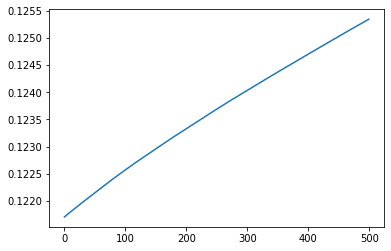

In [13]:
plt.plot(np.mean(abs(testing_sims[0].filamentState[:,onSwitches]),axis=1))

In [14]:
# for i in range(3, 6):
#     plt.plot(abs(np.append(training_sims[-1].electrodeCurrent[:,i], testing_sims[0].electrodeCurrent[:,i+6])))
    
# # plt.ylim(0, 0.6)

In [15]:
# #PLOT TRAINING CURVE:
# # plt.plot(training_sims[0].electrodeCurrent[:,0:3])
# plt.plot(np.vstack((training_sims[-1].electrodeCurrent[:,0:3],testing_sims[0].electrodeCurrent[:,[0,2,4]])))
# plt.figure()
# plt.plot(testing_sims[0].electrodeCurrent[:,[0,2,4]])
# plt.plot(testing_sims[0].electrodeCurrent[:,[1,3,5,6,7,8]])


In [16]:
# print(training_list)
# print(testing_list)
# print(boolTargets)
# print(b_training)
# print(b_testing)

In [17]:
def drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets):

    #Compare training current output of target drains (open) with testing current output of target drains (open)
    drain_training={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}
    drain_testing={'Target':[None]*num_drain_training, 'Non-Target':[None]*(num_drain_testing-num_drain_training)}

    if num_drain_training == 3:
        #Target Drains: 
        temp=b_testing[drainAndSourceTargets]
        drain_training['Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp[0])
        drain_training['Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp[1])
        drain_training['Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp[2])

        drain_testing['Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp[0])
        drain_testing['Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp[1])
        drain_testing['Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp[2])

        #Compare training current output of non-target drains (closed) with testing current output of non-target drains (open)
        #Non-Target Drains: 
        temp2=b_testing[~drainAndSourceTargets]
        drain_training['Non-Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp2[0])
        drain_training['Non-Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp2[1])
        drain_training['Non-Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp2[2])
        drain_training['Non-Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp2[3])
        drain_training['Non-Target'][4]=wireCurrentTimeSeries(training_sims[-1], temp2[4])
        drain_training['Non-Target'][5]=wireCurrentTimeSeries(training_sims[-1], temp2[5])

        drain_testing['Non-Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp2[0])
        drain_testing['Non-Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp2[1])
        drain_testing['Non-Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp2[2])
        drain_testing['Non-Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp2[3])
        drain_testing['Non-Target'][4]=wireCurrentTimeSeries(testing_sims[-1], temp2[4])
        drain_testing['Non-Target'][5]=wireCurrentTimeSeries(testing_sims[-1], temp2[5])
        
    elif num_drain_training == 4:
        #Target Drains: 
        temp=b_testing[drainAndSourceTargets]
        drain_training['Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp[0])
        drain_training['Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp[1])
        drain_training['Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp[2])
        drain_training['Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp[3])
        
        drain_testing['Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp[0])
        drain_testing['Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp[1])
        drain_testing['Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp[2])
        drain_testing['Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp[3])

        #Compare training current output of non-target drains (closed) with testing current output of non-target drains (open)
        #Non-Target Drains: 
        temp2=b_testing[~drainAndSourceTargets]
        drain_training['Non-Target'][0]=wireCurrentTimeSeries(training_sims[-1], temp2[0])
        drain_training['Non-Target'][1]=wireCurrentTimeSeries(training_sims[-1], temp2[1])
        drain_training['Non-Target'][2]=wireCurrentTimeSeries(training_sims[-1], temp2[2])
        drain_training['Non-Target'][3]=wireCurrentTimeSeries(training_sims[-1], temp2[3])
        drain_training['Non-Target'][4]=wireCurrentTimeSeries(training_sims[-1], temp2[4])

        drain_testing['Non-Target'][0]=wireCurrentTimeSeries(testing_sims[-1], temp2[0])
        drain_testing['Non-Target'][1]=wireCurrentTimeSeries(testing_sims[-1], temp2[1])
        drain_testing['Non-Target'][2]=wireCurrentTimeSeries(testing_sims[-1], temp2[2])
        drain_testing['Non-Target'][3]=wireCurrentTimeSeries(testing_sims[-1], temp2[3])
        drain_testing['Non-Target'][4]=wireCurrentTimeSeries(testing_sims[-1], temp2[4])

    return drain_training,drain_testing

In [18]:
b_testing[drainAndSourceTargets]

array([194, 127, 264, 128])

In [19]:
#Assign Data to Target and Non-Target
drain_training,drain_testing=drains_assign(testing_sims,training_sims,b_training,b_testing,num_drain_training,drainAndSourceTargets)

In [20]:
#CROSS CORRELATION:

sclistTarget=[None]*len(drain_testing['Target'])
sclistNonTarget=[None]*len(drain_testing['Non-Target'])

# DOT PRODUCT CROSS CORRLATION
for i in range(len(drain_testing['Target'])):
    a=drain_training['Target'][i][:500].reshape(-1)
    b=drain_testing['Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistTarget[i]=np.dot(a,b) 
        
for i in range(len(drain_testing['Non-Target'])):
    a=drain_training['Non-Target'][i][:500].reshape(-1)
    b=drain_testing['Non-Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistNonTarget[i]=np.dot(a,b)
    
#Adrian Cross Correlation    
# I_ave=[None]*numSessions
# I_tar=[None]*numSessions
# sclist[0],I_tar[0],I_ave[0]=cross_correlation_adrian(testing_sims[-1],boolTargets)

In [21]:
sclistTarget

[9.675372226417128e-07,
 2.04393343721765e-07,
 4.265825709219298e-06,
 4.15350211018316e-06]

In [22]:
sclistNonTarget

[6.399916335400978e-12,
 5.2716572242606914e-14,
 1.4465250481431354e-13,
 4.20874779641102e-14,
 8.397221844917734e-15]

[]

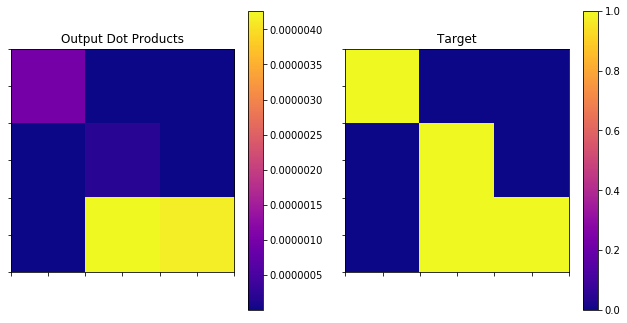

In [37]:
grid = np.zeros(9)

gridTarget=[i for i, x in enumerate(boolTargets) if x]
gridNonTarget=[i for i, x in enumerate(boolTargets) if ~x]

grid[gridvalues] = sclistTarget
grid[gridNonTarget] = sclistNonTarget
    
grid=(grid.reshape(3,3))

fig1 = plt.figure(figsize=(11,11))
ax1=fig1.add_subplot(1, 2, 1)
ax1.title.set_text('Output Dot Products')
plt.imshow(grid,interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)
# plt.axis('off')

ax2=fig1.add_subplot(1, 2, 2)
ax2.title.set_text('Target')
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)


#Remove Tick Labels
fig1.axes[0].get_xaxis().set_ticklabels([])
fig1.axes[0].get_yaxis().set_ticklabels([])
fig1.axes[2].get_xaxis().set_ticklabels([])
fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(grid[0]))

In [27]:
#Repeat Training + Testing:

#Training:
for i in range(numTraining,numTraining*numSessions):
    print("Training " + str(i+1))
    #PUT IN REST FOR SECOND TRAINING
    training_sims.append(runSim(connectivity, start_state=resting_state[-1], stimulus=training_stimulus, contactMode='preSet', electrodes=b_training,T=run_time, onAmp=onAmp_training, dt=dt, f=f, findFirst=False,collapse=True))
    training_state.append(getJunctionState(training_sims[i]))
#Testing
for i in range(numTesting,numTesting*numSessions):
    print("Testing " + str(i+1))
    testing_sims.append(runSim(connectivity, start_state=training_state[-1], stimulus=testing_stimulus, contactMode='preSet', electrodes=b_testing,T=signal_time, onAmp=onAmp_testing, dt=dt, f=f, findFirst=False,collapse=True))
    
    testing_state.append(getJunctionState(testing_sims[i]))

Training 4


IndexError: list index out of range

In [28]:
# sclist[1],I_tar[1],I_ave[1]=cross_correlation(testing_sims[-1])
drain_training,drain_testing=drains_assign(testing_sims,training_sims[3:],b_training,b_testing)

sclistTarget=[None]*len(drain_testing['Target'])
sclistNonTarget=[None]*len(drain_testing['Non-Target'])

# DOT PRODUCT CROSS CORRLATION
for i in range(len(drain_testing['Target'])):
    a=drain_training['Target'][i][:500].reshape(-1)
    b=drain_testing['Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistTarget[i]=np.dot(a,b) 
        
for i in range(len(drain_testing['Non-Target'])):
    a=drain_training['Non-Target'][i][:500].reshape(-1)
    b=drain_testing['Non-Target'][i].reshape(-1)
    #take the first 500 seconds of training signal and compare to testing signal
    sclistNonTarget[i]=np.dot(a,b)

IndexError: list index out of range

In [27]:
sclistTarget

[4.421959287572562e-07, 9.102236077737579e-07, 3.984958082393152e-06]

In [28]:
sclistNonTarget

[1.3860277381351106e-13,
 7.884012669829159e-14,
 8.60671889229895e-14,
 2.4547644081653075e-14,
 2.040095629938732e-09,
 2.692382134608084e-09]

[]

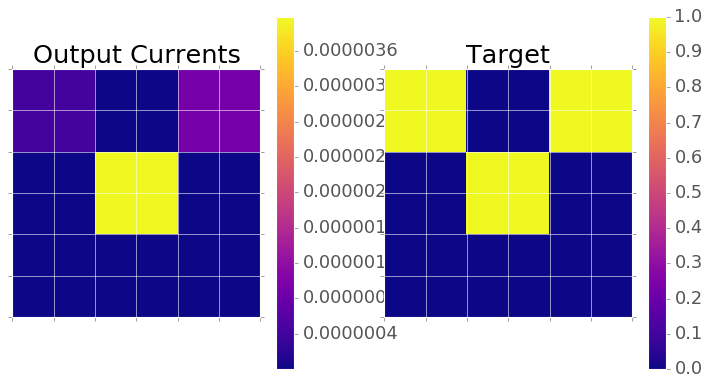

In [32]:
grid = np.zeros(9)
grid[[0,2,4]] = sclistTarget
grid[[1,3,5,6,7,8]] = sclistNonTarget
grid=grid.reshape(3,3)

fig1 = plt.figure(figsize=(11,11))
ax1=fig1.add_subplot(1, 2, 1)
ax1.title.set_text('Output Currents')
plt.imshow(grid,interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)
# plt.axis('off')

ax2=fig1.add_subplot(1, 2, 2)
ax2.title.set_text('Target')
plt.imshow((boolTargets.reshape(3,3)).astype(int),interpolation='none',cmap='plasma')
plt.colorbar(shrink=0.5)


#Remove Tick Labels
fig1.axes[0].get_xaxis().set_ticklabels([])
fig1.axes[0].get_yaxis().set_ticklabels([])
fig1.axes[2].get_xaxis().set_ticklabels([])
fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(grid[0]))

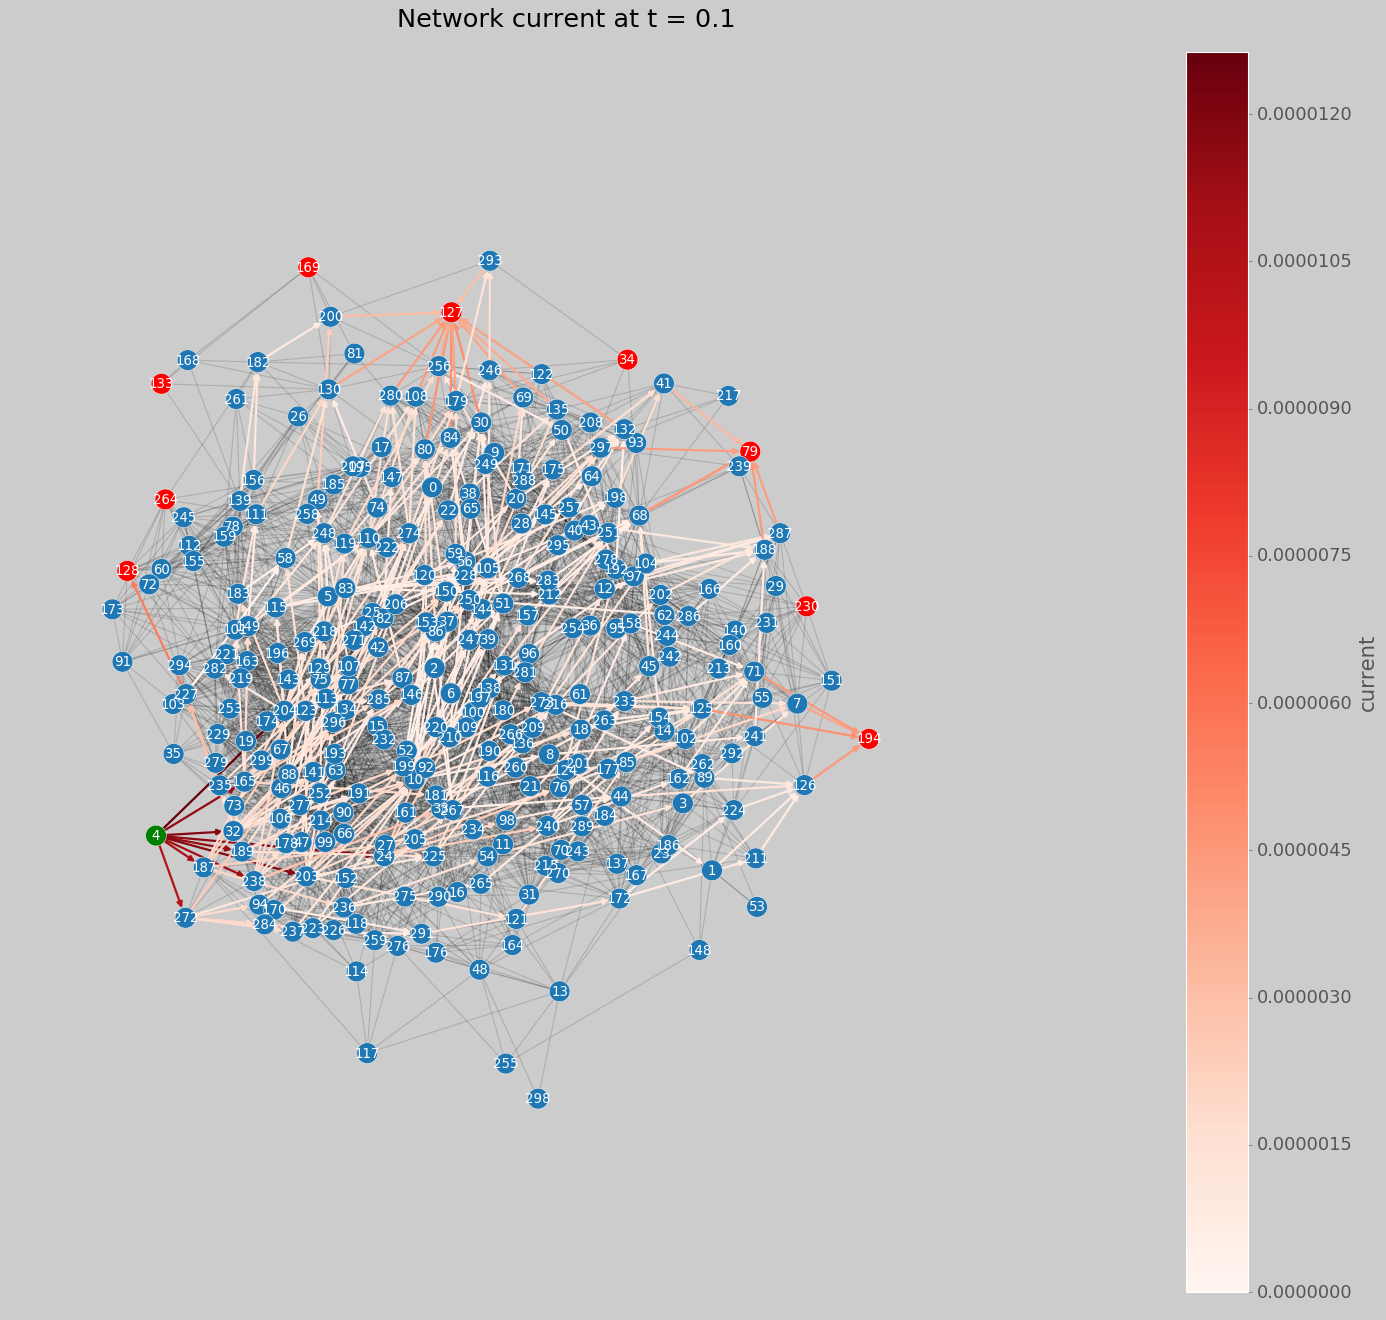

In [34]:
#Visualise Testing Electrode Positions
draw_graph(testing_sims[1], time = 0.1, figsize=(20,20),colorbar=True)

In [26]:

# fig1 = plt.figure(figsize=(11,11))
# fig1.add_subplot(1, 2, 1)
# plt.imshow(I_tar[1].astype(int).reshape(3,3),cmap='plasma')
# plt.colorbar(shrink=0.5)
# # plt.axis('off')

# fig1.add_subplot(1, 2, 2)
# plt.imshow(I_ave[1].reshape(3,3),cmap='plasma')
# plt.colorbar(shrink=0.5)
# #Remove Tick Labels
# fig1.axes[0].get_xaxis().set_ticklabels([])
# fig1.axes[0].get_yaxis().set_ticklabels([])
# fig1.axes[2].get_xaxis().set_ticklabels([])
# fig1.axes[2].get_yaxis().set_ticklabels([])
# plt.text(-4,4,'Cross-Correlation = ' + str(sclist[1]))

# # im1 = axes[0].imshow(I_tar.astype(int).reshape(3,3),cmap='plasma')
# # im2 = axes[1].imshow(I_ave.reshape(3,3),cmap='plasma')

In [17]:
# Cross Correlation:
def cross_correlation_adrian(testing_sims,boolTargets):
    avecurr=[]
    I_ave=[]
    I_tar=[]
    un=[]
    dos=[]
    newcurr=[]
    sclist=[]
    avecurr=np.mean(testing_sims.electrodeCurrent[:,0:9],0) #find the average current for each training simulation for each drain electrode

    # #sclist=zeros(1,length(avecurr));
#     for i in range(len(avecurr)):
    I_ave=avecurr #average current at the ith channel
    I_tar=boolTargets #logical of which channels were used;

    un=(I_ave-np.mean(I_ave))
    dos=(I_tar-np.mean(I_tar))

    u=np.dot(un,dos)
    d=np.sqrt(np.sum(un**2)*np.sum(dos**2))

    sclist=u/d 
    return sclist, I_tar,I_ave